1 . СБОР ДАННЫХ  
2 . ОЧИСТКА ДАННЫХ  
3 . РАЗВЕДЫВАТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ  
3.1 Удаление строковых значений  
3.2 Очистка от пропущенных значений. Замена пропущенных значений  
3.3 Создание новых признаков  
3.4 Преобразование признаков. Нормализация, стандартизация  
3.5 Отбор признаков. Используем анализ мультиколлинеарности и значимости признаков как шаг отбора признаков для модели  
4 . Создание и обучение модели RandomForestRegressor  
5 . Анализ важности признака, исходя из построения дерева решений  
6 . Подготовка submission

In [126]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
import re # Библиотека для регулярных выражений
import category_encoders as ce # импорт для работы с кодировщиком

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Rui\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [127]:
#!pip install geocoder
import geocoder 

In [128]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [129]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

Первоначальная версия датасета содержит 17 полей со следующей информацией:  
<span style="color:grey">hotel_address — адрес отеля;  
review_date — дата, когда рецензент разместил соответствующий отзыв;  
average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;  
hotel_name — название отеля;  
reviewer_nationality — страна рецензента;  
negative_review — отрицательный отзыв, который рецензент дал отелю;  
review_total_negative_word_counts — общее количество слов в отрицательном отзыв;  
positive_review — положительный отзыв, который рецензент дал отелю;  
review_total_positive_word_counts — общее количество слов в положительном отзыве;  
reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;  
total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;  
total_number_of_reviews — общее количество действительных отзывов об отеле;  
tags — теги, которые рецензент дал отелю;  
days_since_review — количество дней между датой проверки и датой очистки;  
additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.  
lat — географическая широта отеля;  
lng — географическая долгота отеля.</span>

In [130]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

In [131]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [132]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [133]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [134]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [135]:
sample_submission.head(2)

,reviewer_score,id
0,8.377,488440
1,7.147,274649


In [136]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [137]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\Rui\AppData\Local\Temp\ipykernel_10712\1819849330.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


# 2. Очистка данных
На этапе очистки данных мы определяем пропущенные значения, аномалии и выбросы в данных.

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

<span style="color:red">Пропущенные значения присутствуют в признаках 'lat' и 'lng'.</span>

In [139]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,49.442439,2.823803,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,3.466325,4.579425,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214662,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,0.010607,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,51.516288,4.834443,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.000000,10.000000


Есть подозрение на наличие аномалий в признаках 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts',  'total_number_of_reviews_reviewer_has_given'.  
Построим их распределение.

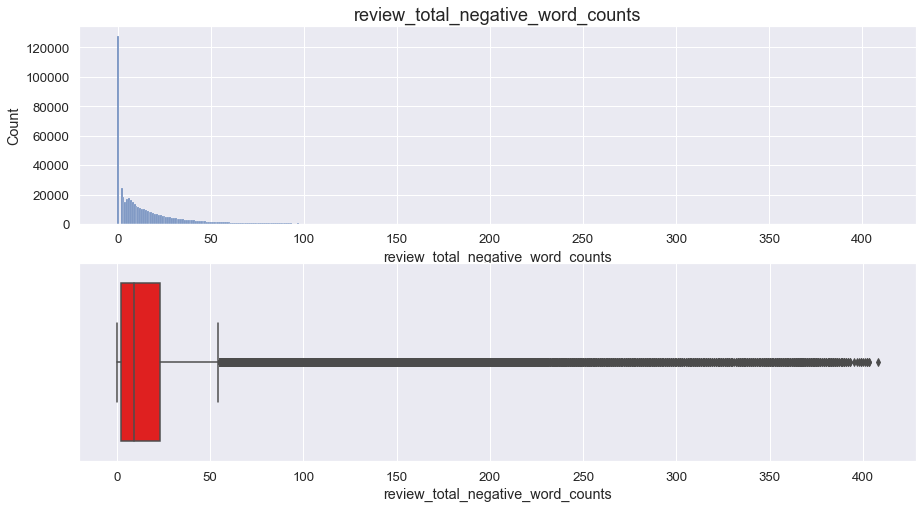

In [140]:
# Создадим холст и оси
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
sns.set(font_scale = 1.2)

axes[0].set_title('review_total_negative_word_counts', fontsize=18)       # Заголовок

# Построим гистограмму распределения признака "review_total_negative_word_counts"
histplot = sns.histplot(
    data=data,
    x='review_total_negative_word_counts',
    discrete=True,
    ax=axes[0]
)
# Построим коробчатую диаграмму признака "review_total_negative_word_counts"
sns.boxplot(
    data=data,
    x='review_total_negative_word_counts',
    color='red',
    ax=axes[1]
);

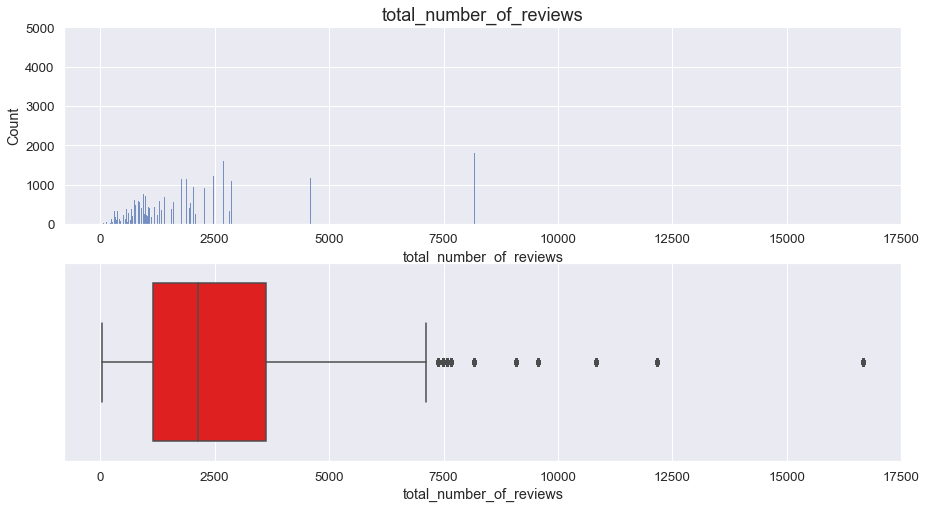

In [141]:
# Создадим холст и оси
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
sns.set(font_scale = 1.2)

axes[0].set_title('total_number_of_reviews', fontsize=18)       # Заголовок

# Построим гистограмму распределения признака "total_number_of_reviews"
histplot = sns.histplot(
    data=data,
    x='total_number_of_reviews',
    discrete=True,
    ax=axes[0]
)
# Построим коробчатую диаграмму признака "total_number_of_reviews"
sns.boxplot(
    data=data,
    x='total_number_of_reviews',
    color='red',
    ax=axes[1]
);

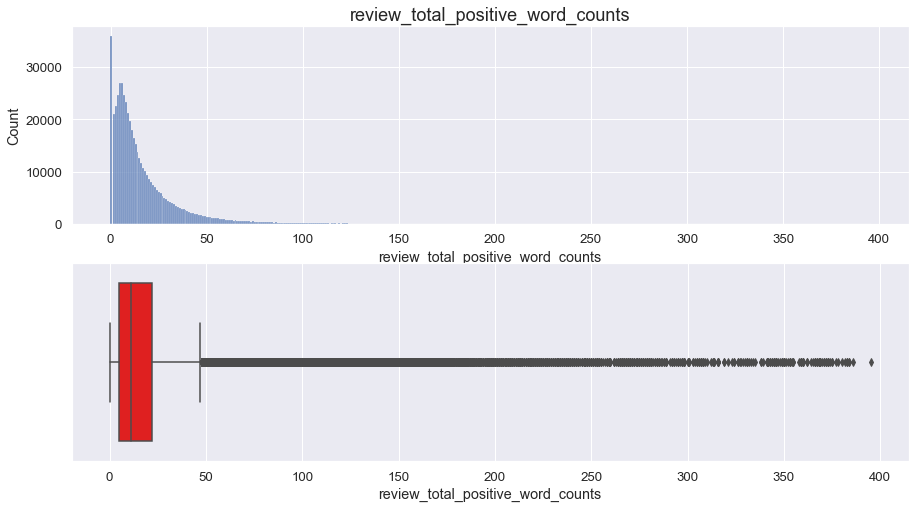

In [142]:
# Создадим холст и оси
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
sns.set(font_scale = 1.2)

axes[0].set_title('review_total_positive_word_counts', fontsize=18)       # Заголовок

# Построим гистограмму распределения признака "review_total_positive_word_counts"
histplot = sns.histplot(
    data=data,
    x='review_total_positive_word_counts',
    discrete=True,
    ax=axes[0]
)
# Построим коробчатую диаграмму признака "review_total_positive_word_counts"
sns.boxplot(
    data=data,
    x='review_total_positive_word_counts',
    color='red',
    ax=axes[1]
);

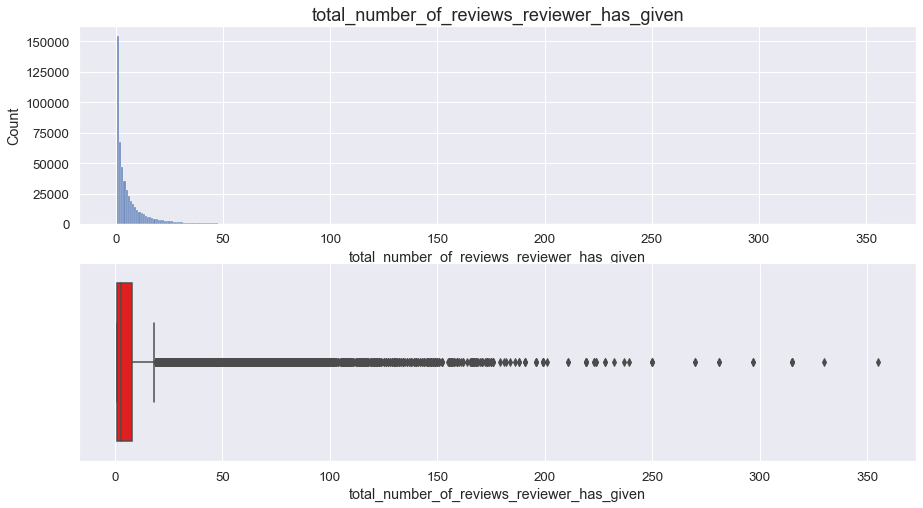

In [143]:
# Создадим холст и оси
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
sns.set(font_scale = 1.2)

axes[0].set_title('total_number_of_reviews_reviewer_has_given', fontsize=18)       # Заголовок

# Построим гистограмму распределения признака "total_number_of_reviews_reviewer_has_given"
histplot = sns.histplot(
    data=data,
    x='total_number_of_reviews_reviewer_has_given',
    discrete=True,
    ax=axes[0]
)
# Построим коробчатую диаграмму признака "total_number_of_reviews_reviewer_has_given"
sns.boxplot(
    data=data,
    x='total_number_of_reviews_reviewer_has_given',
    color='red',
    ax=axes[1]
);

Субъективно под подозрение попадают значения признака 'total_number_of_reviews' — общее количество действительных отзывов об отеле больше 10000 и значения признака 'total_number_of_reviews_reviewer_has_given' — количество отзывов, которые рецензенты дали в прошлом больше 250. По условиям задачи исключать строки нельзя, поэтому оставлю пока эти признаки без фильтрации.   
<span style="color:yellow">Возможно, имеет смысл вернуться к вопросу замены предполагаемых аномалий другими значениями позже.</span>

# 3. РАЗВЕДЫВАТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ 
## 3.1. Удаление строковых значений

In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### 3.1.1.  'hotel_address'

In [157]:
# Множество уникальных адресов
list(set(data['hotel_address']))[::5]
print('Всего уникальных адресов', len(set(data['hotel_address'])))
print('Примеры уникальных адресов')
list(set(data['hotel_address']))[::150]

Всего уникальных адресов 1493
Примеры уникальных адресов


['Engerthstra e 173 175 02 Leopoldstadt 1020 Vienna Austria',
 '4 rue de la P pini re 8th arr 75008 Paris France',
 '64 Boulevard de Grenelle 15th arr 75015 Paris France',
 'Passeig de Gracia 132 Gr cia 08008 Barcelona Spain',
 'Palaud ries 26 Sants Montju c 08004 Barcelona Spain',
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
 'Via Mazzini 4 Milan City Center 20123 Milan Italy',
 '9 Villa de Saxe 7th arr 75007 Paris France',
 '9 Rue de Washington 8th arr 75008 Paris France',
 'Paseo de Gracia 75 Eixample 08008 Barcelona Spain']

In [146]:
# Выделение страны из адреса отеля
data['country'] = data['hotel_address'].apply(
    lambda x: x.split()[-2] +' '+ x.split()[-1] if x.split()[-1] == 'Kingdom' else  x.split()[-1])
print('Уникальные страны')
print(set(data['country']))

Уникальные страны
{'Spain', 'United Kingdom', 'France', 'Netherlands', 'Austria', 'Italy'}


In [147]:
# Выделение города из адреса отеля
data['city'] = data['hotel_address'].apply(
    lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else  x.split()[-2] )
uniq_city = set(data['city'])
print('Уникальные города')
print(uniq_city)

Уникальные города
{'London', 'Barcelona', 'Milan', 'Paris', 'Vienna', 'Amsterdam'}


In [148]:
# Между городами и странами существует однозначное соответствие. Поэтому один признак можно удалить, а другой закодировать.
encoder = ce.OneHotEncoder(cols=['country']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)
data = data.drop(['country'],  axis = 1)
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lng,sample,reviewer_score,city,country_1,country_2,country_3,country_4,country_5,country_6
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,9.171102,0,0.0,Milan,1,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,4.834443,0,0.0,Amsterdam,0,1,0,0,0,0


Предполагается использование признака 'city' для вычисления расстояния от отеля до центра города.  
<span style="color:yellow">Удалить позже.</span>  
<span style="color:red">=============NB!=============</span> 

In [151]:
# Выделение почтового индекса из адреса отеля
data['zip'] = data['hotel_address'].apply(lambda x: x.split()[-4]+' '+x.split()[-3] if x.split()[-1] == 'Kingdom' or x.split()[-1] == 'Netherlands' else x.split()[-3])
data['zip'].sample(10)

429049       75010
391192       08002
183895     SE1 7RY
56480        20124
339083    SW1P 4DD
103730     W14 0QL
137762      W8 5SP
80469      1101 AX
161729      W2 3DP
351268      W2 3DP
Name: zip, dtype: object

In [152]:
print('Количество уникальных почтовых индексов {}'.format(len(set(data['zip'])))) 

Количество уникальных почтовых индексов 601


In [153]:
# Кодирование информации о почтовом индексе:
data['zip'] = data['zip'].astype('category')
data['zip_cat'] = data['zip'].cat.codes

data = data.drop(['zip'],  axis = 1)

In [154]:
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,sample,reviewer_score,city,country_1,country_2,country_3,country_4,country_5,country_6,zip_cat
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0.0,Milan,1,0,0,0,0,0,187
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,0,0.0,Amsterdam,0,1,0,0,0,0,87


Предполагается использование данных адреса отеля для заполнения пропусков в признаках географической долготы и широты.  
<span style="color:yellow">Удалить позже.</span>  
<span style="color:red">=============NB!=============</span> 

### 3.1.2. 'review_date'
review_date — дата, когда рецензент разместил соответствующий отзыв

In [155]:
# Можно предположить зависимость от сезона. Как определить высокий сезон, выделить месяц или неделю, пока непонятно.
# День года содержит максимум информации и позволяет провести в дальнейшем последующую обработку при целесообразности.

data["review_date"] = pd.to_datetime(data["review_date"])
data["review_day"] = data["review_date"].dt.dayofyear
data.drop("review_date", axis=1, inplace=True)

### 3.1.3. 'hotel_name'

In [163]:
# Отели с одинаковым названием, но разными адресами
grouped_data = data.groupby(['hotel_name','hotel_address'])['sample'].count().sort_values()
grouped_data.groupby('hotel_name').count().sort_values(ascending=False)[:3]


hotel_name
Hotel Regina                       3
11 Cadogan Gardens                 1
Mercure Paris Gare Montparnasse    1
Name: sample, dtype: int64

In [167]:
print('Адреса отелей с одинаковым названием\n', list(data[data['hotel_name'] == 'Hotel Regina']['hotel_address'].unique()))

Адреса отелей с одинаковым названием
 ['Bergara 2 4 Eixample 08002 Barcelona Spain', 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria', 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy']


Три отеля, расположенные в разных городах, называются одинаково Hotel Regina. Дополню название отеля городом, в котором он находится.

In [31]:
data.loc[(data['hotel_address'] == 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria'),
         'hotel_name'] = 'Hotel Regina Vienna'
data.loc[(data['hotel_address'] == 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy'),
         'hotel_name'] = 'Hotel Regina Milan'
data.loc[(data['hotel_address'] == 'Bergara 2 4 Eixample 08002 Barcelona Spain'),
         'hotel_name'] = 'Hotel Regina Barcelona'

Единственную практическую пользу в названии отеля я вижу только в определении принадлежности отеля к крупной сети.

In [32]:
# Список сетей
hotel_chains = ['Britannia', 'Park Plaza', 'Hilton', 'Holiday Inn', 'Intercontinental',
               'Park Grand', 'Taj', 'Montcalm', 'Best Western', 'Guoman',
               'Ramada', 'Golden Tulip', 'citizenM', 'Club Quarters', 'Crowne Plaza',
               'Mariott', 'Mercure', 'Radisson', 'Novotel', 'DoubleTree']

# Подготовка шаблона для регулярного выражения, чтобы не делать вручную
print(','.join(hotel_chains).replace(',','|'))

Britannia|Park Plaza|Hilton|Holiday Inn|Intercontinental|Park Grand|Taj|Montcalm|Best Western|Guoman|Ramada|Golden Tulip|citizenM|Club Quarters|Crowne Plaza|Mariott|Mercure|Radisson|Novotel|DoubleTree


In [33]:
data['chain'] = data['hotel_name'].apply(
    lambda x: (re.search(
r'Britannia|Park Plaza|Hilton|Holiday Inn|Intercontinental|Park Grand|Taj|Montcalm|Best Western|Guoman|Ramada|Golden Tulip|citizenM|Club Quarters|Crowne Plaza|Mariott|Mercure|Radisson|Novotel|DoubleTree',
    x)[0]) if (re.search(
r'Britannia|Park Plaza|Hilton|Holiday Inn|Intercontinental|Park Grand|Taj|Montcalm|Best Western|Guoman|Ramada|Golden Tulip|citizenM|Club Quarters|Crowne Plaza|Mariott|Mercure|Radisson|Novotel|DoubleTree',
    x) is not None) else 'not_chain'
    )
data['chain'].value_counts()

not_chain           358847
Hilton               20242
Holiday Inn          15874
DoubleTree           15248
Best Western         15025
Park Plaza           13531
Radisson             11250
Mercure              10424
Novotel               9838
Park Grand            7492
Montcalm              5248
citizenM              5216
Crowne Plaza          4864
Club Quarters         4793
Britannia             4789
Guoman                3637
Golden Tulip          2616
Intercontinental      2551
Taj                   2203
Ramada                2050
Name: chain, dtype: int64

In [34]:
# Кодирование информации о принадлежности отелей к сетям

bin_encoder = ce.BinaryEncoder(cols=['chain']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['chain'])
data = pd.concat([data, type_bin], axis=1)

#data.head(2)
data = data.drop(['chain', 'hotel_name'],  axis = 1)

### 3.1.4. 'reviewer_nationality'
страна рецензента

In [35]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())
n_nat = len(data["reviewer_nationality"].value_counts())
print(f'Представители {n_nat} стран являются рецензентами.')

# Кодирование информации о стране рецензента:
data['reviewer_nationality'] = data['reviewer_nationality'].astype('category')
data['reviewer_nat_cat'] = data['reviewer_nationality'].cat.codes

data = data.drop(['reviewer_nationality'],  axis = 1)

Представители 227 стран являются рецензентами.


### 3.1.5. 'negative_review', 'positive_review'
negative_review — отрицательный отзыв, который рецензент дал отелю  
positive_review — положительный отзыв, который рецензент дал отелю

In [36]:
# Пакет символьной и статистической обработки естественного языка для анализа отзывов
sent_analyzer = SentimentIntensityAnalyzer()

# Анализ отзывов
# Столбцы исходных признаков заполняются словарями с ключами 'neg', 'neu', 'pos', 'compound и соответствующими значениями
data['negative_review_dict'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['positive_review_dict'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# Распаковка словарей в отдельные признаки
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['negative_review_dict'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['positive_review_dict'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.head(2)

data = data.drop(['negative_review_dict', 'positive_review_dict', 'negative_review', 'positive_review'], axis=1)

### 3.1.6. 'tags' 
теги, которые рецензент дал отелю

In [37]:
# Обработка признака tags
# Пробовал различные варианты: 1, 5, 10, 20 топ-тэгов, начинал не с самых популярных,
# предполагая их не очень информативными (с 5-го по 15-й, например). 
# Также пробовал начинать анализ с конца списка по популярности.
# Увеличение числа анализуруемых топ-тэгов дает прирост метрики, но все более незначительный.
# Ограничился условно-разумным максимумом.

tags_dict = {}
def tags_proc(tags):
    """Принимает на вход исходное значение признака 'tags';
    возвращает очищенную от лишних знаков строку тэгов.
    Формирует словарь-счетчик тэгов как глобальную переменную
    за один проход таблицы"""
    global tags_dict
    tag_list = tags.replace("[' ", '').replace(" ']", '').split(" ', ' ")
    for tag in tag_list:
        if tag not in tags_dict:
            tags_dict[tag] = 0
        else:
            tags_dict[tag] +=1
    return str(tag_list)

data['tags'] = data['tags'].apply(tags_proc)

# сортировка словаря тэгов
sorted_tuples = sorted(tags_dict.items(), key=lambda item: item[1], reverse=True)
sorted_tags_dict = {k: v for k, v in sorted_tuples}

# отбор топ 20 тегов
top_tags = list(sorted_tags_dict.keys())[:20]
# Кодирование информации признака 
for tag_ in top_tags:
    data[tag_] = data.apply(lambda x: 1 if tag_ in x.tags else 0, axis=1)
    
data = data.drop(['tags'],  axis = 1)

### 3.1.7. 'days_since_review' 
количество дней между датой проверки и датой очистки

In [38]:
# Извлечение числового значения
data["days_since_review"] = data["days_since_review"].apply(lambda x: int(x.split()[0]))

## 3.2 Очистка от пропущенных значений. Замена пропущенных значений

Пропущенные значения присутствуют в признаках 'lat' и 'lng'.

In [39]:
# Создание DataFrame c нулевыми признаками широты и долготы.
data = data.fillna(0)
# Создание списка уникальных адресов с отсутствующими координатами.
df_null_geo = data[(data['lat'] ==0) | (data['lng'] ==0 )]
address_null_geo = list(set(df_null_geo['hotel_address']))
display(address_null_geo)

['Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
 '23 Rue Damr mont 18th arr 75018 Paris France',
 'Bail n 4 6 Eixample 08010 Barcelona Spain',
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
 '4 rue de la P pini re 8th arr 75008 Paris France',
 '20 Rue De La Ga t 14th arr 75014 Paris France',
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
 'Sep lveda 180 Eixample 08011 Barcelona Spain',
 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
 'Pau Clar s 122 Eixample 08009 Barcelona Spain']

Все уникальные адреса с отсутствующими координатами имеют ошибки, связанные с наличием символов, отсутствующих в стандартной английской раскладке клавиатуры.  
Составим словарь с исправленными адресами вручную, используя поиск Google.

In [40]:
dict = {'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria' : 'Josefstädter Str. 10-12, 1080 Wien', 
        'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria' : 'Währinger Str. 33-35, 1090 Wien',
        '4 rue de la P pini re 8th arr 75008 Paris France' : '17 Rue de la Pépinière, 75008 Paris', 
        'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria' : 'Landstraßer Gürtel 5/03, 1030 Wien',
        'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria' : 'Währinger Straße 15, 1090 Vienna, Austria',
        'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria' : 'Savoyenstraße 2, 1160 Wien',
        'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria' : 'Sieveringer Str. 4, 1190 Wien',
        'Bail n 4 6 Eixample 08010 Barcelona Spain' : 'C/ de Bailèn, 4-6, 08010 Barcelona',
        'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria' : 'Grünentorgasse 30, 1090 Vienna, Austria',
        'Hasenauerstra e 12 19 D bling 1190 Vienna Austria' : 'Hasenauerstraße 12. Wien 1190. Austria',
        'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria' : 'Josefstädter Straße 22, 1080 Vienna, Austria',
        '23 Rue Damr mont 18th arr 75018 Paris France' : '23 Rue Damrémont, 75018 Paris',
        'Paragonstra e 1 11 Simmering 1110 Vienna Austria' : 'Paragonstraße 1, 1110 Wien',
        '20 Rue De La Ga t 14th arr 75014 Paris France' :'20 Rue de la Gaité, 75014 Paris',
        'Pau Clar s 122 Eixample 08009 Barcelona Spain' : 'Carrer de Pau Claris, 122, 08009 Barcelona',
        'Sep lveda 180 Eixample 08011 Barcelona Spain' :'Carrer de Sepúlveda, 180, 08011 Barcelona',
        'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria':'Taborstrasse 8A 02 Leopoldstadt 1020 Vienna Austria'}

In [41]:
# Создание датафрейма geo_df со старым и скорректированным адресом и нулевыми координатами.
geo_df = pd.DataFrame({
    'address': address_null_geo,
    'fill_lat': 0,
    'fill_lng': 0
})

geo_df['address_new'] = geo_df['address']
geo_df.replace({"address_new": dict}, inplace = True)

In [42]:
# Используя geocoder, заменим нули в geo_df правильными координатами. (С адресами с ошибками geocoder работает неправильно.)

geo_df['fill_lat']=geo_df['address_new'].apply(lambda x: geocoder.opencage(x,  key='d0240d2c18b7407eacffe80ac56bf0f9',timeout=None ).json['lat'])
geo_df['fill_lng']=geo_df['address_new'].apply(lambda x: geocoder.opencage(x,  key='d0240d2c18b7407eacffe80ac56bf0f9',timeout=None ).json['lng'])

geo_df

,address,fill_lat,fill_lng,address_new
0,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,48.220835,16.366645,"Grünentorgasse 30, 1090 Vienna, Austria"
1,23 Rue Damr mont 18th arr 75018 Paris France,48.888881,2.333195,"23 Rue Damrémont, 75018 Paris"
2,Bail n 4 6 Eixample 08010 Barcelona Spain,41.388800,2.159000,"C/ de Bailèn, 4-6, 08010 Barcelona"
3,Paragonstra e 1 11 Simmering 1110 Vienna Austria,48.186721,16.420653,"Paragonstraße 1, 1110 Wien"
4,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,48.209834,16.347562,"Josefstädter Str. 10-12, 1080 Wien"
5,4 rue de la P pini re 8th arr 75008 Paris France,48.875005,2.322376,"17 Rue de la Pépinière, 75008 Paris"
6,20 Rue De La Ga t 14th arr 75014 Paris France,32.767300,-96.777600,"20 Rue de la Gaité, 75014 Paris"
7,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...,48.209664,16.351426,"Josefstädter Straße 22, 1080 Vienna, Austria"
8,Sep lveda 180 Eixample 08011 Barcelona Spain,41.383234,2.162940,"Carrer de Sepúlveda, 180, 08011 Barcelona"
9,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,48.219572,16.285626,"Savoyenstraße 2, 1160 Wien"


In [43]:
# Создадим новый датафрейм merged, добавив столбцы 'fill_lng' и 'fill_lat', заполненные только ранее пропущенными координатами, 
# к главному датафрейму, 
merged = data.merge(
    geo_df,
    left_on ='hotel_address',
    right_on ='address',
    how='left'
)
# Заполним нулями отсутствующие значения в датафрейме merged. Это позволит получить признаки координат
# простым сложением соответствующих столбцов.
merged = merged.fillna(0)
merged['lng'] = merged['lng'] + merged['fill_lng']
merged['lat'] = merged['lat'] + merged['fill_lat']

data = merged.drop(['fill_lng', 'fill_lat', 'address', 'address_new'], axis = 1)

In [44]:
# Теперь можно вернуться к п.3.1.1 и удалить строковые данные
data = data.drop(['hotel_address'],  axis = 1)

## 3.3. Создание новых признаков

### 3.3.1. Расстояние от отеля до центра города

In [45]:
# создаю словарь с координатами центров городов вручную, используя Google
city_coordinates = {'Amsterdam': (52.373062, 4.892629),
 'Barcelona': (41.37527, 2.149),
 'London': (51.508039, -0.128069),
 'Milan': (45.464736, 9.18873),
 'Paris': (48.8534100, 2.3488000),
 'Vienna': (48.2092, 16.3728)
 }

In [46]:
# вычисляю расстояние до центра города
import geopy
from geopy.distance import geodesic
data['distance_to_center'] = data.apply(lambda x: geopy.distance.geodesic((x.lat, x.lng), city_coordinates[x.city]).m, axis=1)

In [47]:
# Теперь можно вернуться к п.3.1.1 и удалить строковые данные
data = data.drop(['city'],  axis = 1)

### 3.3.2. Соотношение количества позитивных и негативных слов отзыве

In [48]:
# добавим доли позитивных и негативных слов в общем количестве слов в отзыве, 
# +1 в знаменателе, чтобы избежать ошибки при делении на 0
data['rate_pos_neg_words_in_review'] = data['review_total_positive_word_counts'] / (data['review_total_negative_word_counts']+1)

In [49]:
# Проверяем наличие необработанных признаков 
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
object_columns

[]

In [50]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,...,Standard Double Room,Superior Double Room,Family with older children,Deluxe Double Room,Double or Twin Room,Stayed 5 nights,Standard Double or Twin Room,Classic Double Room,distance_to_center,rate_pos_neg_words_in_review
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,...,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,5.157380e+05,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,354.441932,49.431254,2.886360,0.749999,...,0.070573,0.069124,0.051090,0.053861,0.164578,0.040418,0.035231,0.034066,3.814107e+03,6.022878
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,208.928124,3.463117,4.743194,0.433014,...,0.256110,0.253666,0.220181,0.225743,0.370799,0.196937,0.184364,0.181398,6.737132e+04,13.647263
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,32.767300,-96.777600,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.847369e+01,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,175.000000,48.214277,-0.143372,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.543230e+03,0.384615
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,353.000000,51.499981,0.019886,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.616936e+03,1.054054
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,527.000000,51.516288,4.841163,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.127638e+03,5.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,730.000000,52.400181,16.429233,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.951939e+06,384.000000


## 3.4. Преобразование признаков. Нормализация, стандартизация

In [51]:
# Список столбцов для преобразования
cols_for_scal = []
for col in list(data.columns):
    if data.max()[col] > 1:
        cols_for_scal.append(col)

cols_for_scal.remove('reviewer_score')

In [52]:
# При прочих равных условиях сравнение результатов действия скалеров представлены в таблице
scalers_comparison = pd.DataFrame({
    'scalers': ['no scalers', 'mm_scaler', 'r_scaler', 's_scaler', 'mm_scaler + s_scaler', 'r_scaler + s_scaler', 
                's_scaler + mm_scaler', 's_scaler + r_scaler'],
    'MAPE': [12.61550, 12.61609, 12.61548, 12.61281, 12.61281,12.61281, 12.61548, 12.61548]
})
scalers_comparison

,scalers,MAPE
0,no scalers,12.61550
1,mm_scaler,12.61609
2,r_scaler,12.61548
3,s_scaler,12.61281
4,mm_scaler + s_scaler,12.61281
5,r_scaler + s_scaler,12.61281
6,s_scaler + mm_scaler,12.61548
7,s_scaler + r_scaler,12.61548


По результатам сравнения незначительно лучшие результаты показывает StandardScaler, но
стандартизация предполагает, что признаки распределены нормально, а это не так. Принимаю решение не использовать стандартизацию и нормализацию.

## 3.5. Отбор признаков.  
Используем анализ мультиколлинеарности и значимости признаков как шаг отбора признаков для модели

In [53]:
# непрерывные признаки:
num_cols = ['days_since_review',    
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'n_neg', 'n_neu', 'n_pos', 'n_compound', 'p_neg',
    'p_neu', 'p_pos', 'p_compound', 'rate_pos_neg_words_in_review',
    'total_number_of_reviews_reviewer_has_given'
    ]
# категориальные признаки:
cat_cols = ['lat', 'lng','country_1', 'country_2',
       'country_3', 'country_4', 'country_5', 'country_6', 'zip_cat', 'review_day', 
       'chain_0', 'chain_1', 'chain_2', 'chain_3', 'chain_4',
       'reviewer_nat_cat', 'Leisure trip',
       'Submitted from a mobile device', 'Couple', 'Stayed 1 night',
       'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights', 'Business trip',
       'Group', 'Family with young children', 'Stayed 4 nights', 'Double Room',
       'Standard Double Room', 'Superior Double Room',
       'Family with older children', 'Deluxe Double Room',
       'Double or Twin Room', 'Stayed 5 nights',
       'Standard Double or Twin Room', 'Classic Double Room', 'distance_to_center',
        'average_score', 'additional_number_of_scoring', 'total_number_of_reviews',
    ]

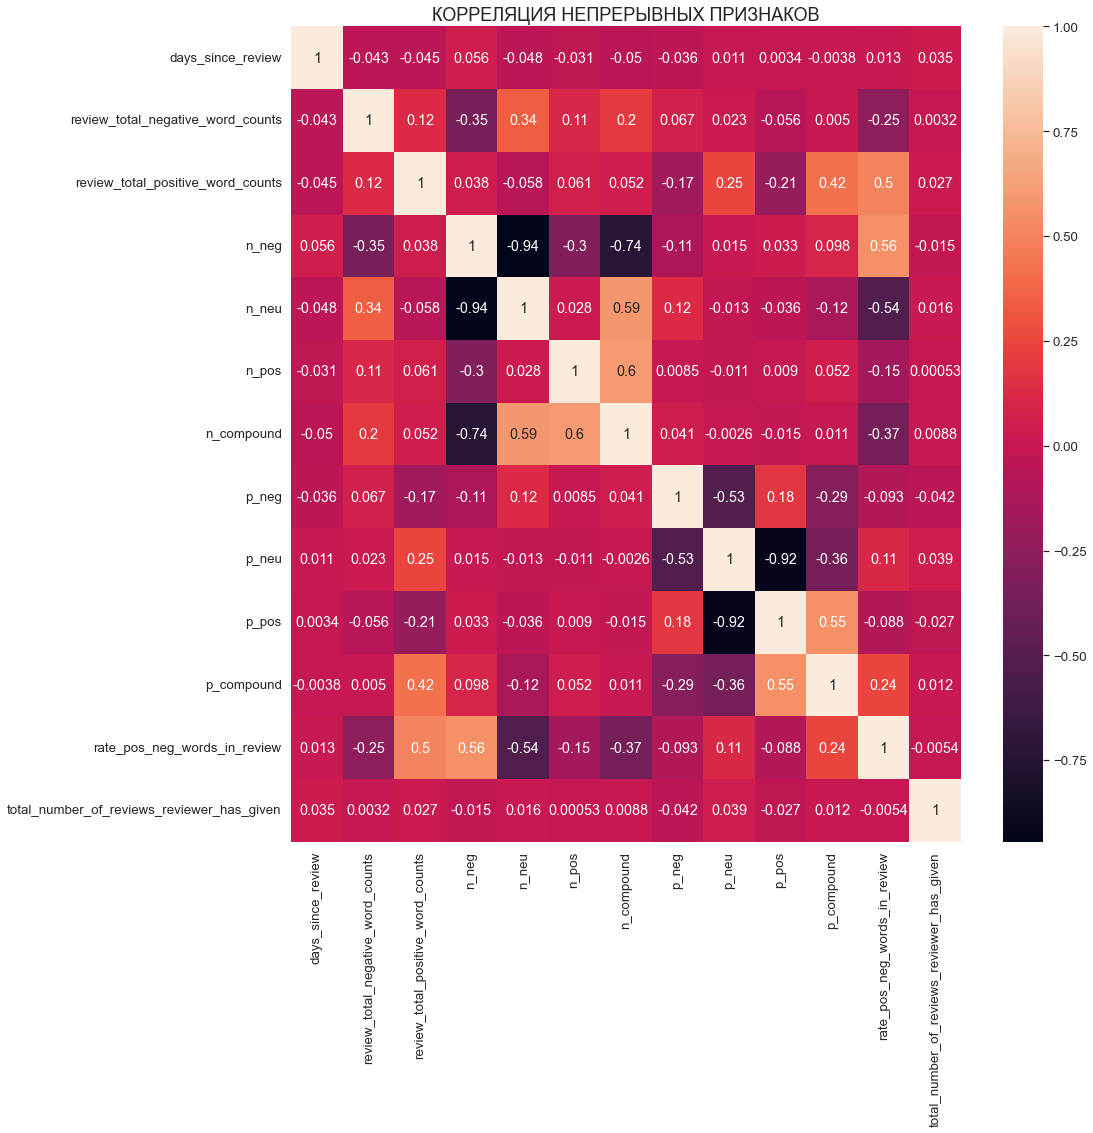

In [54]:
# Построим диаграмму для непрерывных признаков:
fig_, ax_ = plt.subplots(figsize=(15, 15))
corr = data[num_cols].corr(method='pearson')
ax_.set_title('КОРРЕЛЯЦИЯ НЕПРЕРЫВНЫХ ПРИЗНАКОВ', fontsize=18)
sns.heatmap(corr, annot=True);

In [55]:
# Удаление признаков с корреляцией больше 0.9
data = data.drop(['p_neu', 'n_neu'],  axis = 1)

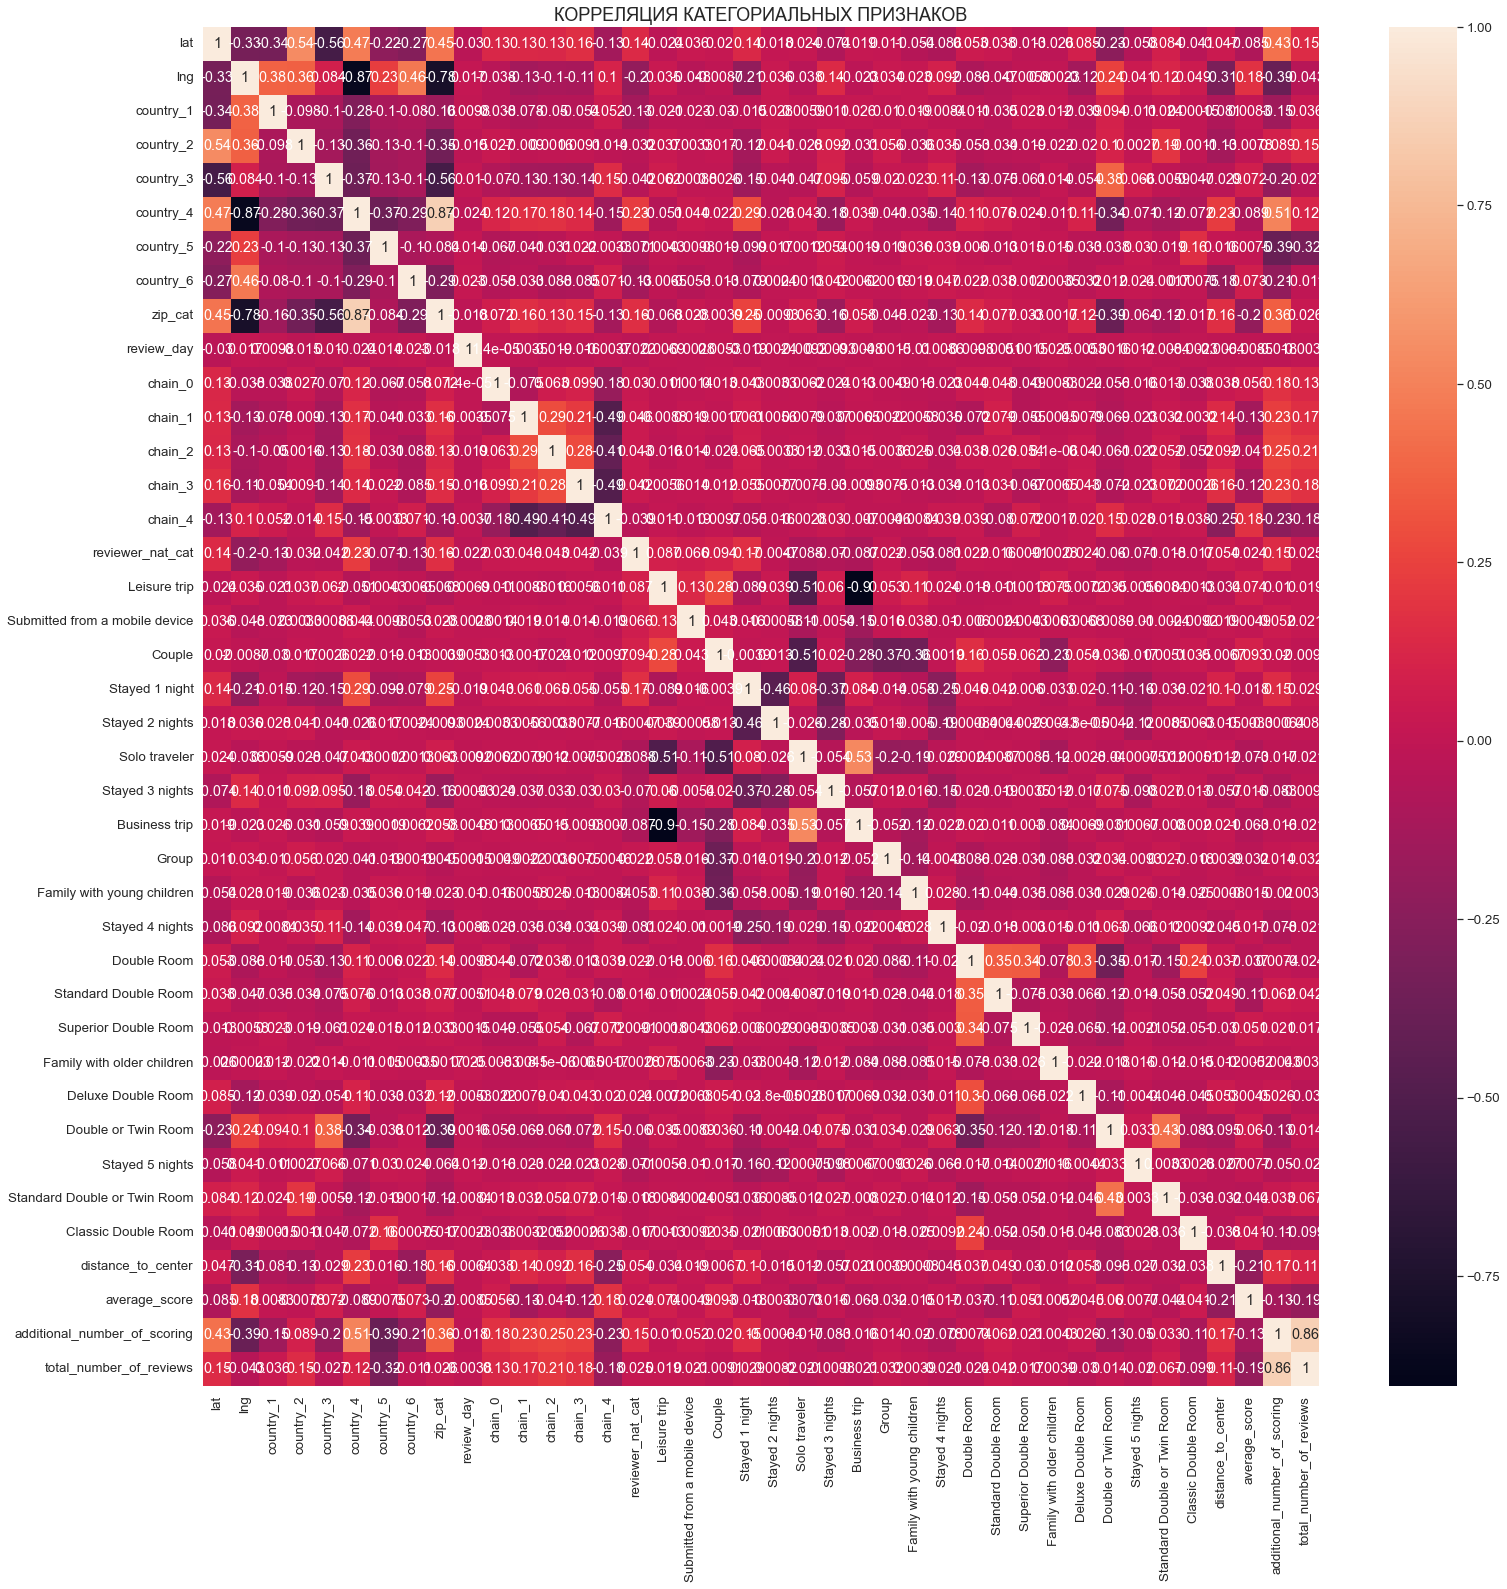

In [56]:
# Построим диаграмму для категориальных признаков:
fig_, ax_ = plt.subplots(figsize=(25, 25))
corr = data[cat_cols].corr(method='spearman')
ax_.set_title('КОРРЕЛЯЦИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ', fontsize=18)
sns.heatmap(corr, annot=True);

In [57]:
# Удаление признаков с корреляцией больше 0.9
data = data.drop(['Business trip'],  axis = 1)

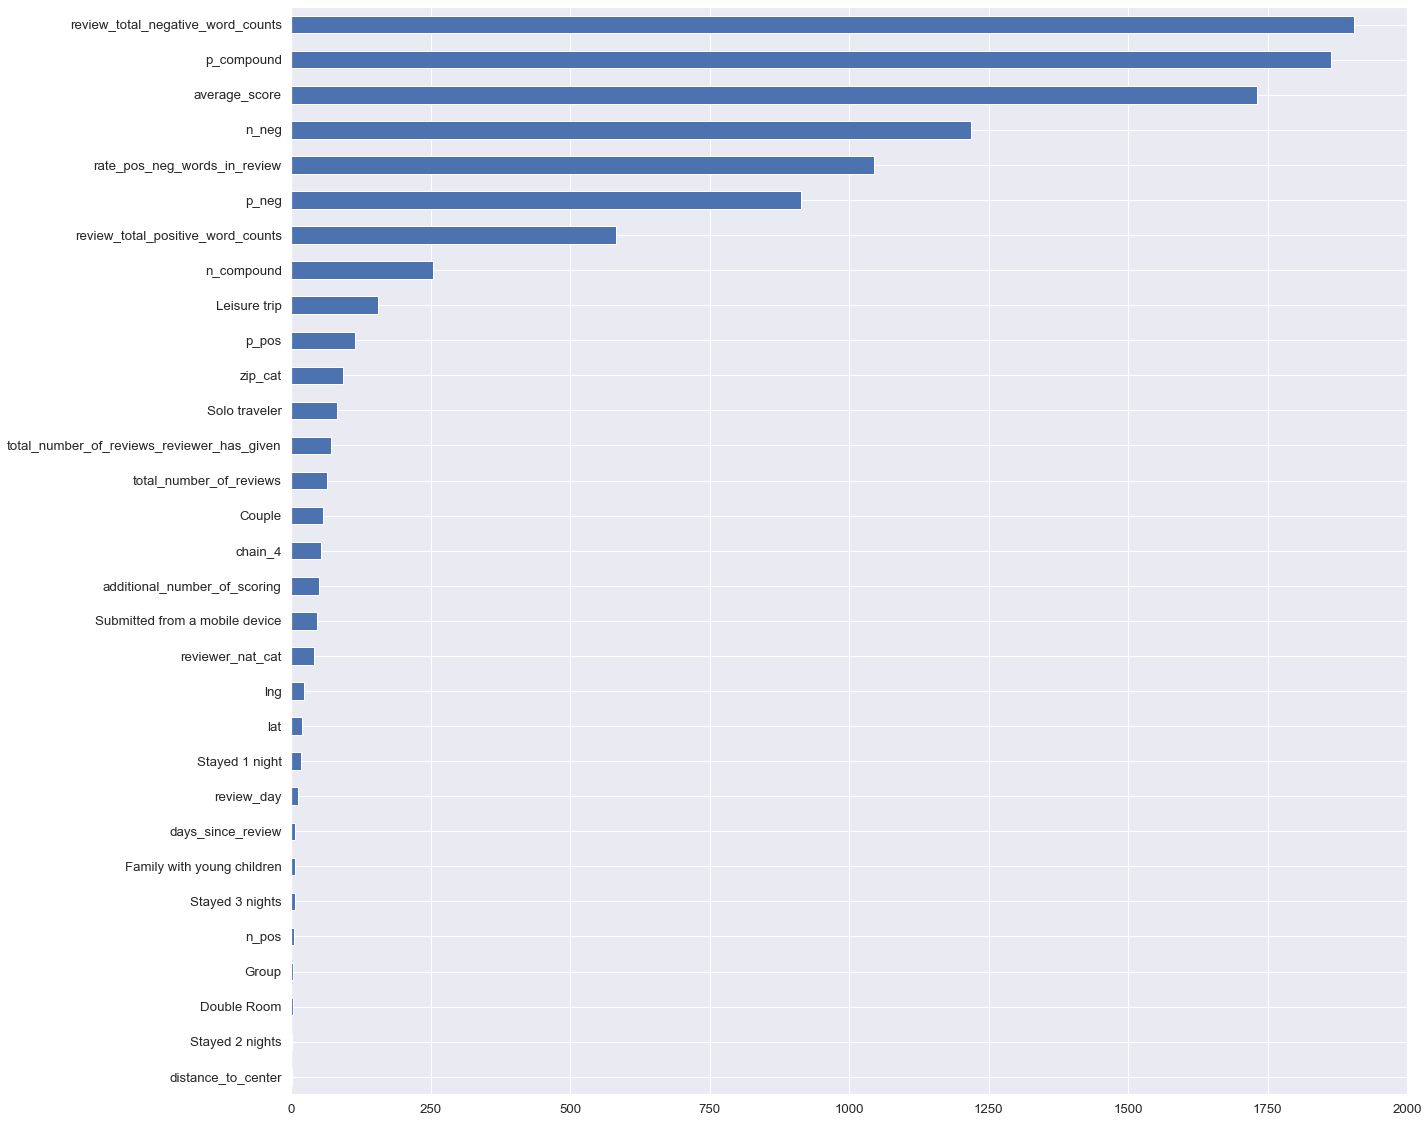

In [75]:
# Используем дисперсионный анализ, показывающий нам различия между признаками

from sklearn.feature_selection import f_classif
y = data.query('sample == 1').drop(['sample'], axis=1)['reviewer_score'].values
#y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

# визуализируем результат анализа значимости:
imp = pd.Series(f_classif(X[X.columns], y)[0], index = X.columns)
imp.sort_values(inplace = True)

fig, ax = plt.subplots(figsize=(20, 20))
imp.plot(kind = 'barh');

In [59]:
# Составим список признаков-кандидатов на удаление на основании предыдущего анализа, закомментировав его, 
# решение об удалении будет принято позже после первого прогона на основании feature_importances_ 

data = data.drop([
                # 'Stayed 2 nights', 
                'Deluxe Double Room', 
                #'Double Room', 
                'Stayed 5 nights', 
                'Family with older children',
                'country_5', 
                #'Group', 
                'country_1', 
                'Standard Double or Twin Room', 
                'Stayed 4 nights', 
                'Classic Double Room',  
                'country_2', 
                'Superior Double Room', 
                #'n_pos',
                'chain_0', 
                'chain_2', 
                #'Stayed 3 nights', 
                #'Family with young children',
                #'days_since_review', 
                #'distance_to_center',
                'Double or Twin Room',  
                #'review_day',
                'country_6', 
                'country_3',
                'country_4', 
                'chain_3',  
                #'Stayed 1 night',
                #'lat', 
                'Standard Double Room', 
                'chain_1'
                ],  
                axis = 1)

In [60]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [61]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [62]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 32), (386803, 32), (386803, 31), (309442, 31), (77361, 31))

# 4. Создание и обучение модели RandomForestRegressor

In [63]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [64]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [65]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished


In [66]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных 
# значений от фактических.
def mean_absolute_percentage_error(y_tr, y_pr):
    """Получение средней абсолютной ошибки"""
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 4))
#print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 12.5242


# 5. Анализ важности признака, исходя из построения дерева решений

<AxesSubplot:>

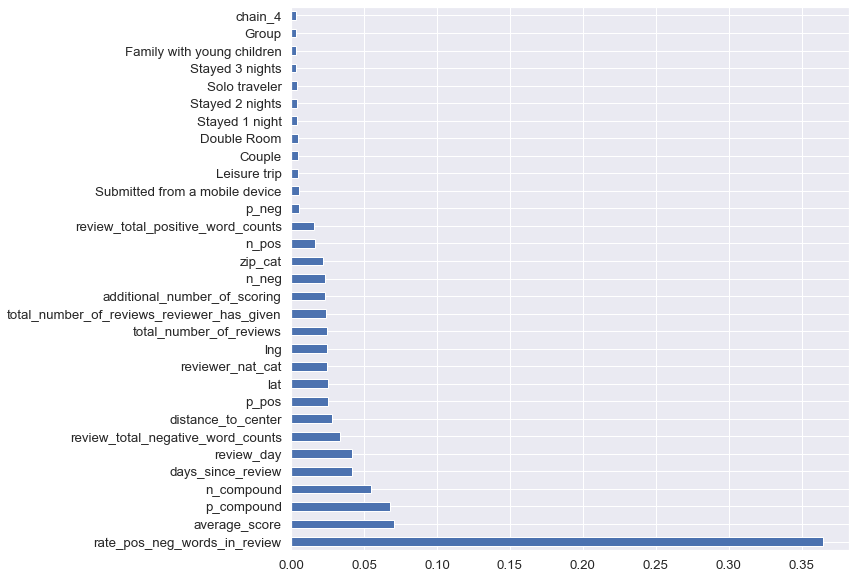

In [67]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
#  feature_importances_ позволяет оценить нам важность признака, исходя из построения дерева решений. 
# Чем чаще используется в узлах признак, тем его приоритет будет выше. 

# На основании этого анализа вернусь к списку признаков-кандидатов на удаление и раскомментирую признаки, 
# наименьшую важность. 

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(60).plot(kind='barh')

# 6. Подготовка submission

In [68]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,...,Couple,Stayed 1 night,Stayed 2 nights,Solo traveler,Stayed 3 nights,Group,Family with young children,Double Room,distance_to_center,rate_pos_neg_words_in_review
103494,368,7.5,28,2092,9,1,452,51.517839,-0.142448,0.0,...,1,1,0,0,0,0,0,1,1478.232178,0.310345
44807,387,8.9,0,2695,9,9,41,41.384829,2.175128,0.0,...,1,0,0,0,0,0,0,0,2429.782546,9.000000
69325,215,8.7,0,2359,17,4,566,41.404738,2.172713,0.0,...,1,0,0,0,0,0,0,0,3826.805533,17.000000
17621,161,8.6,48,761,52,7,532,51.520327,-0.124589,0.0,...,0,1,0,1,0,0,0,0,1388.274299,1.061224
42649,602,8.5,6,2494,7,2,222,51.506935,-0.126012,0.0,...,0,1,0,1,0,0,0,0,188.369983,1.000000
128070,269,7.9,0,835,7,1,671,51.573106,-0.223333,0.0,...,0,1,0,1,0,0,0,0,9802.559737,7.000000
62342,256,8.4,4,2254,29,2,94,41.379013,2.169634,0.0,...,0,0,0,0,1,0,1,0,1775.445122,5.800000
123354,99,8.7,0,1005,11,24,657,48.871602,2.334977,0.0,...,1,1,0,0,0,0,0,0,2263.054586,11.000000
31025,950,8.6,2,3486,3,1,364,51.506472,-0.071689,0.0,...,1,0,1,0,0,0,0,0,3918.293728,1.000000
29887,509,8.4,8,1560,3,1,451,51.501315,-0.217446,0.0,...,1,1,0,0,0,0,0,1,6250.672517,0.333333


In [69]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [70]:
sample_submission

,reviewer_score,id
0,8.320,488440
1,7.267,274649
2,8.070,374688
3,9.678,404352
4,9.580,451596
...,...,...
128930,8.695,495812
128931,9.309,315577
128932,7.968,511968
128933,9.478,303386


In [71]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


In [72]:
predict_submission

array([8.377, 7.147, 8.064, ..., 8.126, 9.493, 7.339])

In [73]:
list(sample_submission)

['reviewer_score', 'id']

In [74]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.377,488440
1,7.147,274649
2,8.064,374688
3,9.638,404352
4,9.635,451596
5,9.156,302161
6,7.845,317079
7,7.677,13963
8,8.656,159785
9,7.208,195089
